In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import re
import chess

# Preparacion de la exploracion

In [4]:
test_path = '/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/raw_lichess_db/lichess_db_standard_rated_2020-02.pgn.bz2'

__CODIGO PARA GENERAR SAMPLE__

In [4]:
!bzcat {test_path} -s | head -n 2000 > ./samples/games_sample.csv


bzcat: I/O or other error, bailing out.  Possible reason follows.
bzcat: Broken pipe
	Input file = /home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/raw_lichess_db/lichess_db_standard_rated_2020-02.pgn.bz2, output file = (stdout)


In [18]:
sample_path = '/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/samples/games_sample.csv'
sample = pd.read_csv(sample_path, sep=';', header=None)

# TRABAJO EN CURSO

In [100]:
def old_read_games(sample_df, games, eval='yes', process_games='process'):
    cols = [
        'Event', 
        'Site', 
        'Date', 
        'Round', 
        'WhiteUser', 
        'BlackUser', 
        'Result', 
        'UTCDate', 
        'UTCTime', 
        'WHiteElo', 
        'BlackElo', 
        'WhiteRatingDiff', 
        'BlackRatingDiff', 
        'ECO', 
        'Opening', 
        'TimeControl', 
        'Termination', 
        'Game'
        ]
    df = pd.DataFrame(columns=cols)
    game_row = 0
    for i in range(0, games):
        vert_game = sample_df.iloc[game_row:game_row+18]
        print(pd.Series(vert_game[0]))
        game = vert_game.transpose()

        if vert_game[0].str.find('WhiteTitle')>=0:
            pass
        elif vert_game[0].str.find('BlackTitle')>=0:
            pass
        else:
            game.columns = cols
            df = pd.concat([df, game])
        game_row += 18
    df.reset_index(drop=True, inplace=True)
    

    # Game processing
    if process_games == 'process':
            # Clean all columns but GAME, which needs to remain raw
            df.loc[:, df.columns != 'Game'] = df.loc[:, df.columns != 'Game'].applymap(lambda x: x.split(' ', 1)[1].replace('"', '')[:-1])
            
            # Format date column
            df['Date'] = pd.to_datetime(df['UTCDate'])

            # Find game type by time control and set a variable for it
            game_type = pd.DataFrame(columns=['Bullet', 'Blitz', 'Rapid', 'Classical'])
            for i in df['Event']:
                bullet = ((i.find('Bullet')>0)*1)
                blitz = ((i.find('Blitz')>0)*1)
                rapid = ((i.find('Rapid')>0)*1)
                classical = ((i.find('Classical')>0)*1)
                gamedf = pd.DataFrame([{'Bullet':bullet,
                                        'Blitz':blitz,
                                        'Rapid':rapid,
                                        'Classical':classical}])
                game_type = pd.concat([game_type, gamedf], ignore_index=True)
            df = df.join(game_type)
            
            # Final Step: Drop unuseful columns
            df.drop(['Event', 'Site', 'ECO', 'BlackRatingDiff', 'WhiteUser', 'BlackUser', 'UTCDate', 'Round'], axis=1, inplace=True)
    # Gets only evaluated games

    if eval == 'yes':
        df = df[df['Game'].apply(lambda x: x.find('eval')>0)==True]


    return df

In [149]:
def clean_line(inputstring):
    return re.findall("\"([^\"]*)\"", inputstring)[0]

In [185]:
def read_games(raw_list, eval='yes'):
    df=pd.DataFrame()
    idx = -1
    
    for line in raw_list:
        if line.startswith('[Event'):
            idx+=1
            df.loc[idx, "Event"] = clean_line(line)
        elif line.startswith('[UTCDate'):
            df.loc[idx, "Date"] = clean_line(line)
        elif line.startswith('[Result'):
            df.loc[idx, "Result"] = clean_line(line)
        elif line.startswith('[WhiteElo'):
            df.loc[idx, "WhiteELO"] = clean_line(line)
        elif line.startswith('[BlackElo'):
            df.loc[idx, "BlackELO"] = clean_line(line)
        elif line.startswith('[Opening'):
            df.loc[idx, "Opening"] = clean_line(line)
        elif line.startswith('[TimeControl'):
            df.loc[idx, "TimeControl"] = clean_line(line)
        elif line.startswith('[Termination'):
            df.loc[idx, "Termination"] = clean_line(line)
        elif line.startswith('[WhiteTitle'):
            df.loc[idx, "WhiteTitle"] = clean_line(line)
        elif line.startswith('[BlackTitle'):
            df.loc[idx, "BlackTitle"] = clean_line(line)
        elif line.startswith('1. '):
            df.loc[idx, "Game"] = str(line)
        else:
            pass
    df.fillna("-", inplace=True)
    if eval == 'yes':
        #df = df[df['Game'].apply(lambda x: x.find('eval')>0)==True]
        try:
            df = df[df['Game'].apply(lambda x: x.find('eval')>0)==True]
        except:
            df = df[df['Game'].apply(lambda x: print(x))]

    
    return df
    

In [161]:
test_sample = !bzcat {test_path} -s | head -n 2000

In [159]:
test = read_games(test_sample)

In [ ]:
test.to_csv('/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/samples/games_processed_sample.csv')

In [198]:
def bash_read_and_save(test_path, startpoint, chunksize, out_path):
    chunk = !bzcat {test_path} | tail -n +{startpoint+1} | head -n {chunksize}
    chunkdf = read_games(chunk)
    chunkdf.to_csv(out_path)

In [202]:
def process_files(dir_path, startpoint=0, chunksize=20000):
    # listamos archivos en la carpeta
    # list to store files
    file_list = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            file_list.append(path)

    # iteramos para cada archivo
    for file in file_list:
        save_path = dir_path+"filtered/"+file
        try:
            !mkdir {save_path}
        except:
            pass
        test_path = dir_path+file
               
        i=True
        while i==True:
            out_path = save_path+"/"+str(startpoint)+"-"+str(startpoint+chunksize)+"_processed.csv"
            try:
                print(startpoint)
                bash_read_and_save(test_path, startpoint, chunksize, out_path)
                startpoint+=chunksize
            except Exception as e:
                print(e)
                i=False
                print("END")


In [203]:
dir_path = '/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/raw_lichess_db/'

process_files(dir_path, chunksize=1_000_000)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000


In [164]:
file_list = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        file_list.append(path)
file = file_list[0]

In [165]:
test_path = dir_path+file
save_path = dir_path+"filtered/"+file
out_path = save_path+"/"+str(0)+"-"+str(100000)+".csv"

In [188]:
chunkdf = read_games(chunk, eval='yes')

In [189]:
chunkdf

,Event,Result,Date,WhiteELO,BlackELO,Opening,TimeControl,Termination,Game,WhiteTitle,BlackTitle
21,Rated Blitz game,1-0,2020.02.01,1791,1829,Queen's Gambit Refused: Marshall Defense,180+2,Normal,1. d4 { [%eval 0.25] [%clk 0:03:00] } 1... d5 ...,-,-
47,Rated Blitz game,1-0,2020.02.01,2120,2104,"Sicilian Defense: Smith-Morra Gambit Accepted,...",300+0,Normal,1. e4 { [%eval 0.24] [%clk 0:05:00] } 1... c5 ...,-,-
65,Rated Rapid game,1-0,2020.02.01,1457,1521,Sicilian Defense: Old Sicilian,600+0,Normal,1. e4 { [%eval 0.24] [%clk 0:10:00] } 1... c5 ...,-,-
66,Rated Rapid game,1-0,2020.02.01,2296,2303,Queen's Pawn Game: London System,600+0,Normal,1. d4 { [%eval 0.25] [%clk 0:10:00] } 1... Nf6...,-,-
68,Rated Rapid game,0-1,2020.02.01,1547,1560,Queen's Pawn Game: Mason Attack,600+0,Normal,1. d4 { [%eval 0.25] [%clk 0:10:00] } 1... d5 ...,-,-
...,...,...,...,...,...,...,...,...,...,...,...
4922,Rated Bullet game,0-1,2020.02.01,1649,1697,St. George Defense,60+0,Normal,1. e4 { [%eval 0.24] [%clk 0:01:00] } 1... a6 ...,-,-
4933,Rated Blitz tournament https://lichess.org/tou...,1-0,2020.02.01,1810,1896,English Opening: The Whale,180+0,Normal,1. e4 { [%eval 0.24] [%clk 0:01:30] } 1... e5 ...,-,-
4946,Rated Bullet game,1-0,2020.02.01,2144,2293,Bird Opening: From's Gambit,120+1,Normal,1. f4 { [%eval -0.1] [%clk 0:02:00] } 1... e5?...,-,-
4949,Rated Rapid game,0-1,2020.02.01,1508,1730,Caro-Kann Defense,1200+0,Normal,1. e4 { [%eval 0.24] [%clk 0:20:00] } 1... c6 ...,-,-


In [1]:

path = '/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/test/lichess_db_standard_rated_2017-01.pgn'

In [15]:

pgn = open(path)

first_game = chess.pgn.read_game(pgn)
second_game = chess.pgn.read_game(pgn)

In [131]:
eval_games = []
i=True
while i==True:
    try:
        game = chess.pgn.read_game(pgn)
        if str(game.mainline_moves()).find('eval')>0:
            eval_games.append(game)
    except Exception as e:
        print(e)
        i=False

    

KeyboardInterrupt: 

In [129]:
eval_games

[<Game at 0x7f59a0ed8b50 ('morhaf' vs. 'Crazy-Monkey', '????.??.??')>,
 <Game at 0x7f59a0eb29b0 ('cristian959' vs. 'michmichlamalice', '????.??.??')>,
 <Game at 0x7f59a0e980d0 ('skillbill' vs. 'rickpa', '????.??.??')>,
 <Game at 0x7f59a0e45ae0 ('Alibatin' vs. 'Mael_Karpov', '????.??.??')>,
 <Game at 0x7f59a0e071c0 ('gomer1377' vs. 'nanchassch', '????.??.??')>,
 <Game at 0x7f59a0eee800 ('dusunoyna' vs. 'arash6613', '????.??.??')>,
 <Game at 0x7f59a0d31180 ('Assassin724' vs. 'BadTigrou', '????.??.??')>,
 <Game at 0x7f59a1cce590 ('entoni77' vs. 'make_a_move', '????.??.??')>,
 <Game at 0x7f59a0e572e0 ('khald' vs. 'ALUCARD662626', '????.??.??')>,
 <Game at 0x7f59a1ccdff0 ('naum1603' vs. 'PILOTVE', '????.??.??')>,
 <Game at 0x7f59a0e073d0 ('reivaxavier1961' vs. 'Rainers2000', '????.??.??')>,
 <Game at 0x7f59a0e6aa40 ('xkl' vs. 'agrichess', '????.??.??')>,
 <Game at 0x7f59a0ed92d0 ('Tekt' vs. 'kryon2020', '????.??.??')>,
 <Game at 0x7f59a0ea6fb0 ('Terminator1' vs. 'aawlbt', '????.??.??')>]

In [39]:
print(game.mainline_moves())

1. e4 e5 2. c3 Nc6 3. Nf3 d6 4. d4 exd4 5. cxd4 Bg4 6. Be2 Bxf3 7. Bxf3 h6 8. d5 Ne5 9. Nc3 a6 10. O-O Be7 11. Re1 Bg5 12. Bxg5 Qxg5 13. Ne2 Nxf3+


In [34]:
for i in game.mainline_moves():
    print(i)

e2e4
e7e5
c2c3
b8c6
g1f3
d7d6
d2d4
e5d4
c3d4
c8g4
f1e2
g4f3
e2f3
h7h6
d4d5
c6e5
b1c3
a7a6
e1g1
f8e7
f1e1
e7g5
c1g5
d8g5
c3e2
e5f3


In [35]:
board = first_game.board()
for move in game.mainline_moves():
    board.push(move)

In [ ]:
board = first_game.board()
for move in second_game.mainline_moves():
    board.push(move)

In [14]:
first_game.headers["Event"]

'Rated Classical tournament https://lichess.org/tournament/Ui35r0ty'

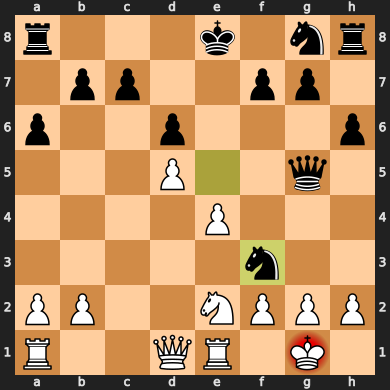

In [36]:
board